# Read Packages

In [6]:
#Python Packages
import os
import math
import copy
from glob import glob
import shutil
import xml.dom.minidom
from xml.dom.minidom import parseString
import xml.etree.ElementTree as et
from xml.dom import minidom

#standard install
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.metrics import structural_similarity as compare_ssim
#Parsing/Modifying XML
from lxml.etree import Element,SubElement,tostring

import data_eng.az_proc as ap
import data_eng.form_calcs as fc
import data_eng.compare as compare

python get_verified_img_parameters.py --verified_state_year_subfolders_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating --verified_standard_quad_subfolders_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_standard_quad_image_name_format  --param_directory \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\params

python make_tile_dir_get_correct_imgs.py --tile_name m_4208431_sw_16_060_20180707 --compile_dir \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir --tile_dir_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\complete_dataset_\tiles

python compare_imgs_by_tile.py --by_tile_correct_chips_wo_black_sq_dir_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir\\m_4007203_ne_18_060_20190811\chips_wo_black --compile_dir \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir --param_directory \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\params

python /hpc/home/csr33/AST_dataset/data_download_and_preprocessing/compare_imgs_by_tile_test.py --by_tile_correct_chips_wo_black_sq_dir /hpc/group/borsuklab/csr33/verifying_images_working_dir/compile_dir/m_4007203_ne_18_060_20190811/chips_wo_black --compile_dir /hpc/group/borsuklab/csr33/verifying_images_working_dir/compile_dir/ --param_directory /hpc/group/borsuklab/csr33/verifying_images_working_dir/param_dir



python compare_imgs_by_tile.py --by_tile_correct_chips_wo_black_sq_dir \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir\\m_4812237_ne_10_060_20190806\chips_wo_black --compile_dir \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir --param_directory \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\params

In [28]:
s = "\\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_2_Tang_Niculescu_Cleave/chips_positive\in_060cm_2018_41085_m_4108534_sw_16_060_20180708_000127.jpg"
d="\\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_standard_quad_image_name_format\verify_Cleave_Sunny_Niculescu_7\chips_positive\m_2909515_se_15_060_20201130_07_04.jpg"
s.rsplit("_",3)
os.path.basename(s).split("_",4)


img_path_to_std_img_name(s)
img_path_to_std_img_name(d)

m_4108534_sw_16_060_20180708_000127
m_2909515_se_15_060_20201130_07_04


# Read in Files 

In [8]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//"
tile_dir = os.path.join(parent_directory,"complete_dataset_","tiles")
#https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

In [9]:
tile_name = "m_4812237_ne_10_060_20190806"
# m_4007203_ne_18_060_20190811
param_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//params"
compile_dir = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//compile_dir"
by_tile_correct_chips_w_black_sq_dir = os.path.join(compile_dir, tile_name, "chips")
by_tile_correct_chips_wo_black_sq_dir = os.path.join(compile_dir, tile_name, "chips_wo_black")
os.makedirs(by_tile_correct_chips_w_black_sq_dir, exist_ok=True)
os.makedirs(by_tile_correct_chips_wo_black_sq_dir, exist_ok=True)

In [ ]:
compare.make_tile_dir_and_get_correct_imgs_w_and_wo_black_sq(tile_name, compile_dir, tile_dir,
                                                            by_tile_correct_chips_w_black_sq_dir,
                                                            by_tile_correct_chips_wo_black_sq_dir)
fc.remove_thumbs(by_tile_correct_chips_wo_black_sq_dir)

In [11]:
state_year_img_paths = fc.read_list(os.path.join(param_directory,"state_year_img_paths.json"))
state_year_xml_paths = fc.read_list(os.path.join(param_directory,"state_year_xml_paths.json"))
state_year_six_digit_idx_list = fc.read_list(os.path.join(param_directory,"state_year_six_digit_idx_list.json"))
standard_img_paths = fc.read_list(os.path.join(param_directory,"standard_img_paths.json"))
standard_xml_paths = fc.read_list(os.path.join(param_directory,"standard_xml_paths.json"))
yx_array = np.load(os.path.join(param_directory,"yx_array.npy"))

In [15]:
correct_chips_wo_black_sq_dir_paths = sorted(glob(by_tile_correct_chips_wo_black_sq_dir + "/*.jpg", recursive = True))
print(len(correct_chips_wo_black_sq_dir_paths))

for correct_img_wo_black_sq_path in correct_chips_wo_black_sq_dir_paths:
    correct_img_wo_black_sq = cv2.imread(correct_img_wo_black_sq_path)
    if np.sum(correct_img_wo_black_sq) != 0:
        correct_img_name = os.path.splitext(os.path.basename(correct_img_wo_black_sq_path))[0] #get correct img name
        row_dim = correct_img_wo_black_sq.shape[0] # get row dim
        col_dim = correct_img_wo_black_sq.shape[1] # get col dim
        if min(row_dim, col_dim) >= 3:
            # identify tile name and indicies from correct img name
            tile_name, y, x, six_digit_idx = correct_img_name.rsplit("-",3)
            by_tile_dir = os.path.join(compile_dir, tile_name) #sub folder for correct directory
            print(correct_img_name, row_dim, col_dim)
            # get standard and state idxs that match the correct img
            state_idxs, = np.where(np.array(state_year_six_digit_idx_list) == six_digit_idx)
            standard_idxs, = np.where((yx_array == (y, x)).all(axis=1))
            # turn the y/x into integers
            y = int(y)
            x = int(x)
            state_year_img_name_wo_ext = tile_name + '_' + six_digit_idx
            standard_quad_img_name_wo_ext = tile_name + '_' + f"{y:02}"  + '_' + f"{x:02}"
            # identify imgs / xmls that match the chip position (state imgs)
            scores = []
            compare_threshold = []
            img_paths = []
            xml_paths = []
            correct_img_names = []
            for idx in state_idxs:
                # get verified img/xml path
                img_path = state_year_img_paths[idx]
                xml_path = state_year_xml_paths[idx]
                img_name = compare.img_path_to_std_img_name(img_path)
                img = cv2.imread(img_path)
                img = img[0:row_dim, 0:col_dim]

                if np.sum(img) != 0:
                    img_paths.append(img_path)
                    xml_paths.append(xml_path)
                    scores = compare.compare_images(correct_img_wo_black_sq, img, scores)
                    compare_threshold.append(compare.specify_compare_threshold(row_dim, col_dim,
                                                                       img_name, state_year_img_name_wo_ext))
                    correct_img_names.append(correct_img_name)

            for idx in standard_idxs:
                img_path = standard_img_paths[idx]
                xml_path = standard_xml_paths[idx]
                img_name = compare.img_path_to_std_img_name(img_path)
                img = cv2.imread(img_path)
                img = img[0:row_dim, 0:col_dim]

                if np.sum(img) != 0:
                    img_paths.append(img_path)
                    xml_paths.append(xml_path)
                    scores = compare.compare_images(correct_img_wo_black_sq, img, scores)
                    compare_threshold.append(compare.specify_compare_threshold(row_dim, col_dim,
                                                                       img_name, standard_quad_img_name_wo_ext))
                    correct_img_names.append(correct_img_name)

            matches = pd.DataFrame(data={'scores': scores, 'compare_threshold': compare_threshold,
                                     'img_paths': img_paths,'xml_paths': xml_paths, "correct_img_names": correct_img_names})

            match = matches.loc[matches['scores'] == max(scores)].iloc[0]
            print(match["correct_img_names"], row_dim, col_dim)
            print(match["scores"], match["compare_threshold"])

424
m_4812237_ne_10_060_20190806-00-00-000001 512 512
m_4812237_ne_10_060_20190806-00-00-000001 512 512
0.6153212067079634 0.9
m_4812237_ne_10_060_20190806-00-01-000002 512 512
m_4812237_ne_10_060_20190806-00-01-000002 512 512
0.8947678067560674 0.875
m_4812237_ne_10_060_20190806-00-02-000003 512 512
m_4812237_ne_10_060_20190806-00-02-000003 512 512
0.559638026600085 0.9
m_4812237_ne_10_060_20190806-00-03-000004 512 512
m_4812237_ne_10_060_20190806-00-03-000004 512 512
0.38561419805307323 0.9
m_4812237_ne_10_060_20190806-00-04-000005 512 512
m_4812237_ne_10_060_20190806-00-04-000005 512 512
0.4440045941613804 0.9
m_4812237_ne_10_060_20190806-00-05-000006 512 512
m_4812237_ne_10_060_20190806-00-05-000006 512 512
0.3798332034706539 0.9
m_4812237_ne_10_060_20190806-00-06-000007 512 512
m_4812237_ne_10_060_20190806-00-06-000007 512 512
0.3802886044721013 0.9
m_4812237_ne_10_060_20190806-00-07-000008 512 512
m_4812237_ne_10_060_20190806-00-07-000008 512 512
0.48629937508186843 0.9
m_4812237

TypeError: 'NoneType' object is not subscriptable

In [18]:
cv2.imread(img_path)[0:row_dim, 0:col_dim]


array([[[157, 162, 153],
        [162, 167, 158],
        [167, 171, 165],
        ...,
        [ 72, 100,  77],
        [ 72, 100,  77],
        [ 74, 102,  79]],

       [[161, 166, 157],
        [164, 169, 160],
        [168, 172, 166],
        ...,
        [ 73, 101,  78],
        [ 72, 100,  77],
        [ 72, 100,  77]],

       [[166, 171, 162],
        [167, 172, 163],
        [168, 172, 166],
        ...,
        [ 76, 102,  79],
        [ 72, 100,  77],
        [ 70,  98,  75]],

       ...,

       [[ 80,  96,  73],
        [ 79,  95,  72],
        [ 78,  94,  71],
        ...,
        [127, 154, 138],
        [112, 144, 125],
        [104, 140, 118]],

       [[ 80,  96,  73],
        [ 79,  95,  72],
        [ 78,  94,  71],
        ...,
        [151, 176, 162],
        [131, 160, 144],
        [115, 147, 128]],

       [[ 80,  96,  73],
        [ 79,  95,  72],
        [ 78,  94,  71],
        ...,
        [172, 197, 183],
        [152, 178, 164],
        [130, 159, 143]]

In [11]:
by_tile_correct_chips_wo_black_sq_dir_paths = sorted(glob(by_tile_correct_chips_wo_black_sq_dir + "/*.jpg", recursive = True))
print(len(by_tile_correct_chips_wo_black_sq_dir_paths))

for by_tile_correct_chips_wo_black_sq_dir_path in by_tile_correct_chips_wo_black_sq_dir_paths:
    correct_img_wo_black_sq = cv2.imread(by_tile_correct_chips_wo_black_sq_dir_path)
    if np.sum(correct_img_wo_black_sq) != 0:
        compare_imgs_wo_blk_pxls_state_yr_std_from_6_digit_xy_idxs_test(correct_img_wo_black_sq, by_tile_correct_chips_wo_black_sq_dir_path,
                                                                   compile_dir, state_year_six_digit_idx_list,
                                                                      state_year_img_paths, state_year_xml_paths,
                                                                      yx_array, standard_img_paths, standard_xml_paths)
    else:
        print("0x")

424
m_4812237_ne_10_060_20190806-00-00-000001 512 512
0.6153212067079634 0.9
\\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_james_poonacha/chips_positive\ok_60cm_2019_35099_m_3509913_sw_14_060_20190627_000001.jpg \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_james_poonacha/chips_positive_xml\ok_60cm_2019_35099_m_3509913_sw_14_060_20190627_000001.xml
m_4812237_ne_10_060_20190806-00-01-000002 512 512
0.8947678067560674 0.875
\\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_poonacha_cleave/chips_positive\wa_60cm_2019_48122_m_4812237_ne_10_060_20190806_000002.jpg \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_poonacha_cleave/chips_positive_xml\wa_60cm_2019_48122_m_4812237_ne_10_060_20190806_000002.xml
match
m_48

TypeError: 'NoneType' object is not subscriptable

# Functions

#

In [14]:
compile_by_tile_dir = os.path.join(parent_directory,"compile_dir")
tile_names = sorted(os.listdir(compile_by_tile_dir))
rename_x_y_index_named_chips(compile_by_tile_dir, tile_names)

In [ ]:
os.path.join(parent_directory,"compile_dir/m_4812237_ne_10_060_20190806/chips/m_4812237_ne_10_060_20190806_24_06.jpg")

In [107]:
(score, diff) = compare_ssim(y,x,full=True)#,multichannel=True)

ValueError: Input images must have the same dimensions.

In [ ]:
make_tile_dir_and_get_correct_imgs(tile_name, compile_dir_path, tile_dir_path)

In [166]:
for tile_name in tqdm.tqdm(sorted(os.listdir(tile_4_dir_path))):
    tile_name = os.path.splitext(tile_name)[0]
    make_tile_dir_and_get_correct_imgs_wo_black(tile_name, take_2, tile_4_dir_path)

  1%|█                                                                              | 11/803 [04:12<5:03:35, 23.00s/it]


KeyboardInterrupt: 

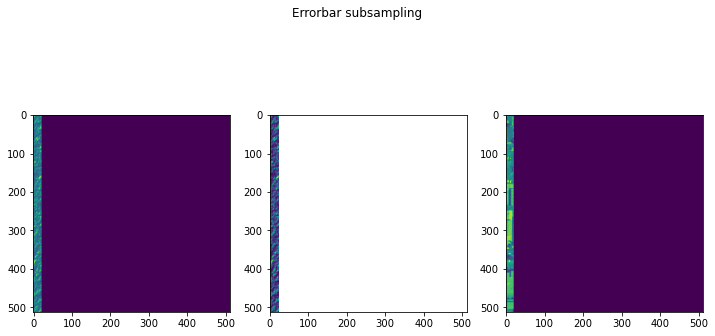

In [186]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 6))

ax0.imshow(a)

ax1.imshow(b)

ax2.imshow(c)

fig.suptitle('Errorbar subsampling')
plt.show()

In [ ]:
            gray_labeled_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY) #image that had been labeled
            ## load correct image from tile             
            y, x = img_name.split("_")[-2:] #name of tif with the extension removed; y=row;x=col
            t_2_chip = tile_to_chip_array(tile, int(x), int(y), int(512)) # load tile to chip
            gray_t_2_chip = cv2.cvtColor(t_2_chip.astype(np.uint8), cv2.COLOR_BGR2GRAY) # make gray
            
            ## check if images are the same


In [23]:
bool_request, contents_json = False, __
contents_json

(512, 22, 3)

In [40]:
x = cv2.cvtColor(cv2.imread(os.path.join(parent_directory,"compile_dir/m_4407521_sw_18_060_20190804/chips/m_4407521_sw_18_060_20190804_24_09.jpg")), cv2.COLOR_BGR2GRAY)[0:3]
y = cv2.cvtColor(cv2.imread(os.path.join(parent_directory,"compile_dir/m_4407521_sw_18_060_20190804/chips/m_4407521_sw_18_060_20190804_24_10.jpg")), cv2.COLOR_BGR2GRAY)[0:3]
compare_ssim(x, y, win_size = 3)# gaussian_weights = True, sigma = 1)

#win_size=None, gradient=False, data_range=None, channel_axis=None, multichannel=False, gaussian_weights=False, full=False, **kwargs)1`

0.7575251596106021